### Решение тестового задания на позицию ведущего специалиста отдела информатизации производства в ООО "Газпром МКС"
***Подготовил: Гергаия Юрий Владимирович***

Контактные данные для связи:

Телефон: *+7 (911) 014-44-02*

Электропочта: *yuriyqc@gmail.com*

### Задание №1: Написание SQL запросов

**Имеются две таблицы:** <br>
cars: car_id, reg_number - таблица машин <br>
orders: order_id, car_id, date_order - таблица заказов <br>

**Задача 1.1**: Вывести все машины (car_id и reg_number), которые совершили более 10 заказов. <br>
**Задача 1.2**: Вывести для каждого месяца в году машины, которые совершили наибольшее кол-во заказов в этом месяце. Результат: таблица со столбцами: month, car_id, reg_number).

Данные задачи будем решать двумя способами:
1. Написанием SQL запросов к БД (без диалекта, т.к. БД не указана)
2. Экспортом таблиц из базы данных в pandas и проведением дальнейших операций там. <br>

Перед тем, как решать задачу, проведем небольшую подготовительную работу - импортируем библиотеку pandasql, которая позволит нам обращаться на декларативном языке SQL к pandas dataframe, который мы создадим и заполним подходящими значениями. 

#### 0. Подготовка к анализу 

Импортируем необходимые библиотеки: 

In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
from faker import Faker # для генерирования данных
faker = Faker('ru_RU') # устанавливаем локаль в генераторе

Генерируем необходимые данные: **car_id** будет состоять из целочисленного массива в диапазоне [1..1000], а reg_number заполним при помощи библиотеки faker (позволяет генерировать различные данные, такие как номер авто в нужной локализации, ФИО, дату рождения, город и прочее)

In [2]:
car_id = np.arange(1, 1001)
reg_number = []
for i in range(1000):
    reg_number.append(faker.license_plate())
cars = pd.DataFrame({'car_id': car_id, 
                     'reg_number': reg_number})

Проверим, правильно ли расставлены типы данных и посмотрим на вывод первых 3х строк нашей будущей БД:

In [3]:
cars.dtypes

car_id         int32
reg_number    object
dtype: object

In [4]:
cars.head(3)

,car_id,reg_number
0,1,ОТ569 82
1,2,008CD5 42
2,3,У827KО 52


Теперь заполним таблицу с заказами (**orders**): самой ранней датой сделаем первый день в текущем году, всего в таблицу загрузим 10000 различных строк (количество можно регулировать переменной n). Столбец order_id будет уникальным пятизначным значением. 

In [5]:
n = 10000
start_date = pd.to_datetime('2022-01-01')

In [6]:
order_id      = np.arange(10000, 99999)
order_id      = np.random.choice(order_id, n, replace = False)
date_order    = pd.date_range(start_date, periods=n, freq='45min')
car_id_orders = np.random.choice(car_id, n)
orders        = pd.DataFrame({'order_id': order_id, 
                             'car_id': car_id_orders, 
                             'date_order': date_order })

Посмотрим, что получилось - правильно ли расставились типы данных, посмотрим количество уникальных значений и сделаем вывод первых 3 строк датафрейма.

In [7]:
orders.nunique()

order_id      10000
car_id         1000
date_order    10000
dtype: int64

In [8]:
orders.dtypes

order_id               int32
car_id                 int32
date_order    datetime64[ns]
dtype: object

In [9]:
orders.head(3)

,order_id,car_id,date_order
0,23485,855,2022-01-01 00:00:00
1,88161,302,2022-01-01 00:45:00
2,88100,870,2022-01-01 01:30:00


На этом подготовительные работы закончены, в результате мы имеем 2 датафрема, которые отвечают условиям задания. 

#### Способ решения №1: через написание SQL запросов

Методика работы с **pandasql** следующая - в переменную пишем SQL запрос, в качестве таблиц используя необходимые ДФ, а для выполнения запроса передаем нашу переменную в функцию sqldf() <br>
Проверим работоспособность, выведя первые 5 строк из таблицы orders

In [10]:
q = """
SELECT *
FROM orders
LIMIT 5
;"""

sqldf(q)

,order_id,car_id,date_order
0,23485,855,2022-01-01 00:00:00.000000
1,88161,302,2022-01-01 00:45:00.000000
2,88100,870,2022-01-01 01:30:00.000000
3,93508,853,2022-01-01 02:15:00.000000
4,57609,240,2022-01-01 03:00:00.000000


Приступаем к решению: <br>
***Задача 1.1: Вывести все машины (car_id и reg_number), которые совершили более 10 заказов.*** <br>
*Примечание: в запросе количество заказов именно превышает 10 (не включая это число), также я вывел еще один дополнительный стоблец, в котором указано количество совершенных заказов каждым reg_number'ом*

In [11]:
answer1 = """
SELECT o.car_id, c.reg_number, COUNT(o.order_id) AS orders_count
FROM orders o 
    LEFT JOIN cars c ON o.car_id = c.car_id
GROUP BY o.car_id
HAVING orders_count > 10
;"""

sqldf(answer1)

,car_id,reg_number,orders_count
0,1,ОТ569 82,15
1,3,У827KО 52,11
2,4,ОН495 43,11
3,8,K1504 79,13
4,11,О506EУ 88,12
...,...,...,...
416,982,B6847 177,12
417,984,K243ХО 26,12
418,987,005CD4 82,12
419,992,007D973 150,14


***Задача 1.2: Вывести для каждого месяца в году машины, которые совершили наибольшее кол-во заказов в этом месяце. (Результат: таблица со столбцами: month, car_id, reg_number).***

Сначала узнаем, какое самое большое число заказов было в каждом из месяцев.

In [12]:
temp_answer2 = """
SELECT Month, MAX(orders_count) AS max_orders
FROM (SELECT strftime('%m', o.date_order) AS Month, 
        c.car_id, c.reg_number, COUNT(order_id) AS orders_count
        FROM orders o
            LEFT JOIN cars c ON o.car_id = c.car_id
        GROUP BY Month, c.car_id)
GROUP BY Month
;"""

sqldf(temp_answer2)

,Month,max_orders
0,01,6
1,02,6
2,03,5
3,04,7
4,05,5
5,06,5
6,07,5
7,08,6
8,09,5
9,10,7


Теперь, при помощи конструкции WITH выберем только те car_id и reg_number, число заказов которых равны максимальному числу заказов в **каждом** из месяцев. Дополнительно, для наглядности в данной таблице я вывел число заказов каждого car_id (соответствующего условию) и максимальное число заказов, чтобы можно было визуально проконтролировать правильность исполнения SQL запроса. 

In [13]:
answer2 = """
WITH car_max_orders AS (
        SELECT Month1, MAX(orders_count) AS max_orders
        FROM (SELECT strftime('%m', o.date_order) AS Month1, 
            c.car_id, c.reg_number, COUNT(order_id) AS orders_count
        FROM orders o
            LEFT JOIN cars c ON o.car_id = c.car_id
            GROUP BY Month1, c.car_id)
        GROUP BY Month1)

SELECT strftime('%m', o.date_order) AS Month, 
        c.car_id, c.reg_number, COUNT(order_id) AS orders_count, cmo.max_orders
FROM orders o
    LEFT JOIN cars c ON o.car_id = c.car_id
    LEFT JOIN car_max_orders cmo ON Month = cmo.Month1
GROUP BY Month, c.car_id
HAVING orders_count == cmo.max_orders
LIMIT 50
;"""

sqldf(answer2)

,Month,car_id,reg_number,orders_count,max_orders
0,01,407,Т3980 74,6,6
1,02,163,B2942 11,6,6
2,03,322,Н8171 750,5,5
3,03,628,0675ХР 03,5,5
4,03,678,1270РС 74,5,5
5,03,837,B920EB 96,5,5
6,04,466,009D481 33,7,7
7,04,564,B1537 159,7,7
8,05,75,ОУ8242 116,5,5
9,05,417,007T101 79,5,5


**ПРИМЕЧАНИЕ**: Изначально, я хотел чтобы месяц был представлен в удобночитаемом виде, а не числом, но как оказалось, диалект при написании запросов все-таки есть - ядром библиотеки pandasql выступает sqlite, которая накладывает ограничение на реализацию запроса: таких функций, как DATEPART(), YEAR(), MONTH() в ней просто нет. Можно вывести месяц другим способом, через функцию "strftime('%m', имя_колонки)", но вывод будет в виде числа от 01 до 12.<br>
Чтобы вывести месяц именем, воспользуемся небольшой помощью со stackoverflow, и немного подкорректируем наш запрос: 

In [14]:
answer2 = """
SELECT (case (Month) when '01' then 'January' 
        when '02' then 'Febuary' when '03' then 'March' when '04' 
        then 'April' when '05' then 'May' when '06' then 'June' 
        when '07' then 'July' when '08' then 'August' when '09' 
        then 'September' when '10' then 'October' when '11' then 
        'November' when '12' then 'December' else '' end) AS Monthname, 
        car_id, reg_number, orders_count, max_orders
FROM (        
    WITH car_max_orders AS (
            SELECT Month1, MAX(orders_count) AS max_orders
            FROM (SELECT strftime('%m', o.date_order) AS Month1, 
                c.car_id, c.reg_number, COUNT(order_id) AS orders_count
            FROM orders o
                LEFT JOIN cars c ON o.car_id = c.car_id
                GROUP BY Month1, c.car_id)
            GROUP BY Month1)

    SELECT strftime('%m', o.date_order) AS Month, 
            c.car_id, c.reg_number, COUNT(order_id) AS orders_count, cmo.max_orders
    FROM orders o
        LEFT JOIN cars c ON o.car_id = c.car_id
        LEFT JOIN car_max_orders cmo ON Month = cmo.Month1
    GROUP BY Month, c.car_id
    HAVING orders_count == cmo.max_orders
    )
;"""

sqldf(answer2)

,Monthname,car_id,reg_number,orders_count,max_orders
0,January,407,Т3980 74,6,6
1,Febuary,163,B2942 11,6,6
2,March,322,Н8171 750,5,5
3,March,628,0675ХР 03,5,5
4,March,678,1270РС 74,5,5
5,March,837,B920EB 96,5,5
6,April,466,009D481 33,7,7
7,April,564,B1537 159,7,7
8,May,75,ОУ8242 116,5,5
9,May,417,007T101 79,5,5


Задача решена, теперь хотелось бы попробовать ее решить другим способом.

#### Способ решения №2: загружаем информацию из БД в pandas, где и будем решать задачу

Загружаем данные из нашей импровизированной БД данные в pandas:

In [15]:
o = """
SELECT *
FROM orders
;"""
orders = sqldf(o)

c = """
SELECT *
FROM cars
;"""
cars = sqldf(c)

Посмотрим, правильно ли распознались типы данных: 

In [16]:
cars.info()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   car_id      1000 non-null   int64 
 1   reg_number  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   order_id    10000 non-null  int64 
 1   car_id      10000 non-null  int64 
 2   date_order  10000 non-null  object
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


Колонка date_order распозналась неправильно, приведем к нужному типу:  

In [17]:
orders['date_order'] = pd.to_datetime(orders['date_order'])

Приступаем к решению: <br>
***Задача 1.1: Вывести все машины (car_id и reg_number), которые совершили более 10 заказов.***

In [18]:
orders.merge(cars, how='left', on='car_id') \
    .groupby(['car_id', 'reg_number'], as_index = False) \
    .agg({'date_order': 'count'}) \
    .rename(columns={'date_order': 'orders_count'}) \
    .query('orders_count > 10') \
    .reset_index()

,index,car_id,reg_number,orders_count
0,0,1,ОТ569 82,15
1,2,3,У827KО 52,11
2,3,4,ОН495 43,11
3,7,8,K1504 79,13
4,10,11,О506EУ 88,12
...,...,...,...,...
416,981,982,B6847 177,12
417,983,984,K243ХО 26,12
418,986,987,005CD4 82,12
419,991,992,007D973 150,14


***Задача 1.2: Вывести для каждого месяца в году машины, которые совершили наибольшее кол-во заказов в этом месяце. Результат: таблица со столбцами: month, car_id, reg_number).***

Соединим ДФ, добавим колонку с названием месяца

In [19]:
all_orders = orders.merge(cars, how='left', on='car_id')
all_orders['monthname'] = all_orders.date_order.dt.month_name()
all_orders.head(3)

,order_id,car_id,date_order,reg_number,monthname
0,23485,855,2022-01-01 00:00:00,РТ5739 58,January
1,88161,302,2022-01-01 00:45:00,Х529СС 37,January
2,88100,870,2022-01-01 01:30:00,ОУ9637 84,January


Узнаем, какое количество заказов было максимальным в каждом из месяцев и присоединим к основному ДФ: 

In [20]:
max_orders_by_month = all_orders.groupby(['monthname', 'car_id'], as_index = False) \
            .agg({'date_order': 'count'}) \
            .groupby(['monthname'], as_index = False) \
            .agg({'date_order': 'max'}) \
            .rename(columns={'date_order': 'max_orders'})
all_orders = all_orders.merge(max_orders_by_month, how='left', on='monthname')  

Решаем задачу: выводим необходимые колонки, считаем, сколько было у каждого car_id и reg_number'а заказов и оставляем только те, у которых количество равно максимальному количеству за месяц. 

In [21]:
max_orders = all_orders.groupby(['monthname', 'car_id', 'reg_number', 'max_orders'], as_index = False) \
    .agg({'date_order': 'count'}) \
    .rename(columns={'date_order': 'month_orders_count'}) \
    .query('month_orders_count == max_orders') 
max_orders

,monthname,car_id,reg_number,max_orders,month_orders_count
292,April,466,009D481 33,7,7
363,April,564,B1537 159,7,7
640,August,49,M2141 62,6,6
1337,February,163,B2942 11,6,6
2077,January,407,Т3980 74,6,6
2459,July,15,2388НK 95,5,5
2707,July,432,008D558 19,5,5
2916,July,753,KР8346 80,5,5
3062,July,981,ХО227 75,5,5
3494,June,681,A302РН 33,5,5


Задача решена. <br>
Мы можем проверить, что ответы в SQL запросе не отличаются от ответов, полученных при запросе с помощью pandas. Для этого, посмотрим описательные статистики для датафреймов:

In [22]:
sql_answer2 = sqldf(answer2)

In [23]:
sql_answer2.describe()

,car_id,orders_count,max_orders
count,23.000000,23.000000,23.000000
mean,507.086957,5.347826,5.347826
std,287.548401,0.775107,0.775107
min,15.000000,4.000000,4.000000
25%,315.000000,5.000000,5.000000
50%,466.000000,5.000000,5.000000
75%,717.000000,5.500000,5.500000
max,982.000000,7.000000,7.000000


In [24]:
max_orders.describe()

,car_id,max_orders,month_orders_count
count,23.000000,23.000000,23.000000
mean,507.086957,5.347826,5.347826
std,287.548401,0.775107,0.775107
min,15.000000,4.000000,4.000000
25%,315.000000,5.000000,5.000000
50%,466.000000,5.000000,5.000000
75%,717.000000,5.500000,5.500000
max,982.000000,7.000000,7.000000


### Задание №2: Отборочное задание

*Для производства продукции используются 8 станков, каждому из которых нужен оператор. <br>
Операторы работают вахтовым методом, вахта состоит из 33 рабочих дней и 23 дней отдыха. Кроме того, в течении года оператор должен взять себе 4 недели отпуска, (можно брать отпуск частями, кратно одной неделе). В течение одной вахты, оператор должен работать на одном и том же станке.<br>
**Задача 2.1**: определить какое минимальное количество операторов необходимо для бесперебойной работы станков в течении года (360 дней).<br>
**Задача 2.2**: составить пример оптимального графика дежурств операторов на 360 дней. (для выполнения этой задачи рекомендуется использование алгоритмических решений.)*

Описание хода решения данной задачи буду вести в этом же ноутбуке, в ячейках ниже.

***Задача 2.1, решение*** <br>
Сначала посчитаем, сколько всего необходимо "станкодней" в течении года

In [25]:
360 * 8

2880

Теперь выведем количество вахт и межвахт, на которые может приехать оператор в течение года (с округлением до 3х знаков): 

In [26]:
round ((360 - 28) / (33 + 23), 3)

5.929

Значит, рабочих дней 1 оператор отработает

In [27]:
5.929 * 33

195.657

Исходя из этого, минимальное количество операторов, необходимых для бесперебойной работы станков в течении года (360 дней) составляет:

In [28]:
2880 / 195.657

14.719636915622747

Ну или если округлить (с округлением в большую сторону до целочисленного значения):

In [29]:
int(-1 * (2880 / 195.657) // 1 * -1)

15

***Задача 2.2, Решение*** <br>

При решении этой задачи возникли сложности. Алгоритм моего решения был следующий:
1. Я нагуглил соответствующий тип задач, под названием Nurse scheduling problem (NSP).
2. Нашел статью на Хабре, о решении подобной задачи на языке MiniZinc ( https://habr.com/ru/company/billing/blog/342550/ )
3. Установил интерпретатор, попытался исполнить приложенный код, код не заработал в разумное время (40 минут расчетов на ЦП Intel(R) Core(TM) i7-8750H)
4. Нашел еще один вариант кода, на англоязычном гитхабе ( https://github.com/hakank/hakank/blob/master/minizinc/nurse_rostering_with_availability.mzn ). 
5. Код запустился, произвел расчеты, заложенные в него автором, но я не смог его адаптировать под свои нужды - с частью переменных в коде я разобрался, но как построить правильную матрицу я не понял, и свалился при выполнении в ошибку "MiniZinc: evaluation error: mismatch in array dimensions: the array contains 98 elements, but 5400 elements were expected according to the given index sets." 
6. Почитал о программировании в ограничениях, но для данной задачи подходящей адаптации не нашел. 
7. Я попробовал адаптировать [данное решение задачи NSP](https://developers.google.com/optimization/scheduling/employee_scheduling#python_1) для нашей текущей задачи, но столкнулся с определенными трудностями в формализации ограничений (в частности, в задаче используются смены (дневная, ночная, выходная) и было бы прекрасно вместо них подставить нашу вариацию вахта/межвахта/отпуск, но смены одинаковые, а в нашем случае ограничения будут разными по времени).<br>

На попытку решения данной задачи было затрачено много времени, алгоритмическое решение мною не найдено. <br><br>
PS: Я даже попытался найти решение этой задачи методом перебора в экселе, но у меня никак не сходились смены (и если начинать отсчет с начала года (с первой смены из 360), то вопреки моим расчетам при решении части 2.1 этой задачи, требуется не 15 операторов, а 16)

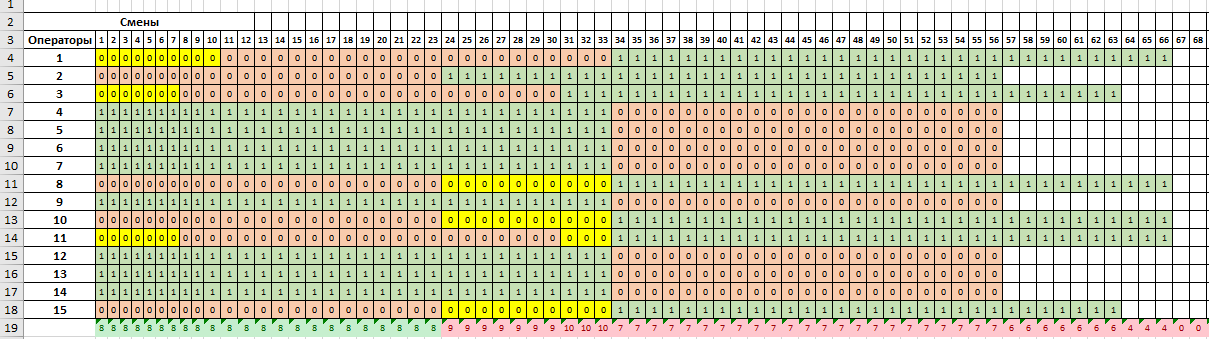